# Selección de Atributos

Primero que todo, se carga el dataframe de la actividad 1

In [6]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from sklearn.preprocessing import StandardScaler
url = 'http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)
istrain_str = df['train']
istrain = np.asarray([True if s == 'T' else False for s in istrain_str])
istest = np.logical_not(istrain)
df = df.drop('train', axis=1)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['lpsa'] = df['lpsa']

X = df_scaled.ix[:,:-1]
N = X.shape[0]
X.insert(X.shape[1], 'intercept', np.ones(N))

y = df_scaled['lpsa']
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
Xt = Xtest.as_matrix()
yt = ytest.as_matrix()

## Forward Step-wise Selection

**Forward Step-wise Selection (FSS)** es una técnica que permite seleccionar iterativamente las mejores características de modelo. Se comienza con un modelo sin características (solo con el `intercept`). En cada iteración se prueba ingresando una nueva característica al modelo y se le asigna un puntaje. Se escoje aquella con el mejor puntaje y se ingresa en el modelo. Este proceso continua hasta que el modelo empeore o se cumpla un criterio de parada.

En este caso se aplico FSS usando el valor absoluto de los pesos de cada predictor o característica al construirse el modelo. En este caso no se incluyó un criterio de parada de forma de poder observar como va cambiando el error cuadrático medio conforme se integran nuevas características.

In [9]:

import sklearn.linear_model as lm
import code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Definicion de fss
#x, y corresponden al conjunto y vector de entrenamiento respectivamente
#xt, yt corresponden al conjunto y vector de prueba respectivamente
#names_x los nombres de las características
#k el número máximo de características
def fss(x, y, xt, yt, names_x, k = 10000):
	p = x.shape[1]-1
	k = min(p, k)
	names_x = np.array(names_x)
	remaining = range(0, p)
	selected = [p]
	current_score = 0.0
	best_new_score = 0.0
	results_train = []
	results_test = []
	while remaining and len(selected)<=k:
		score_candidates = []
		for candidate in remaining:
			model = lm.LinearRegression(fit_intercept=False)
			indexes = selected + [candidate]
			x_train = x[:,indexes]
			model.fit(x_train, y)
			wscore_candidate = abs(model.coef_[indexes.index(candidate)])
			
			residuals_train = model.predict(x_train) - ym
			mse_train_candidate = np.mean(np.power(residuals_train, 2))
			x_test = xt[:,indexes]
			residuals_test = model.predict(x_test) - yt
			mse_test_candidate = np.mean(np.power(residuals_test, 2))
			score_candidates.append((wscore_candidate, candidate, mse_train_candidate, mse_test_candidate))
		score_candidates.sort()

		best_new_score, best_candidate, mse_train, mse_test = score_candidates.pop()
		remaining.remove(best_candidate)
		selected.append(best_candidate)
		results_train.append(mse_train)
		results_test.append(mse_test)

		print "selected = %s ..."%names_x[best_candidate]
		print "totalvars=%d, abs_weight = %f"%(len(indexes),best_new_score)
		print "mse train=%f test=%f"%(mse_train,mse_test)

	return selected, results_train, results_test
                                          


In [10]:
names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45", "Intercept"]
selected, result_train, result_test = fss(Xm,ym,Xt,yt,names_regressors)

selected = Lcavol ...
totalvars=2, abs_weight = 0.835589
mse train=0.664606 test=0.479739
selected = Lweight ...
totalvars=3, abs_weight = 0.314693
mse train=0.553610 test=0.492482
selected = Svi ...
totalvars=4, abs_weight = 0.221538
mse train=0.521011 test=0.400531
selected = Lbph ...
totalvars=5, abs_weight = 0.202079
mse train=0.489776 test=0.456332
selected = Lcp ...
totalvars=6, abs_weight = 0.133718
mse train=0.482430 test=0.474415
selected = Pgg45 ...
totalvars=7, abs_weight = 0.211594
mse train=0.455818 test=0.548593
selected = Age ...
totalvars=8, abs_weight = 0.144280
mse train=0.439363 test=0.516513
selected = Gleason ...
totalvars=9, abs_weight = 0.021195
mse train=0.439200 test=0.521274


Se puede observar como FSS va agregando variables y va disminuyendo el error cuadrático medio del conjunto de entrenamiento, pero no así, el error cuadrático medio del conjunto de pruebas que va variando. Las tres primeras variables con el peso más alto corresponden a aquellas con el z-score más alto y por tanto las con mayor evidencia de relación con el modelo. Curiosamente, no son aquellas con los coeficientes más altos en el modelo completo.

|            | lcavol | lweight | age    | lbph  | svi   | lcp    | gleason | pgg45 | intercept |
|------------|--------|---------|--------|-------|-------|--------|---------|-------|-----------|
|Coeficientes| **0.676**  | **0.262**   | -0.141 | **0.209** | **0.304** | -0.287 | -0.021  | **0.266** | **2.465**     |
|Z-score     | **5.366**  | **2.751**   | -1.396 | **2.056** | **2.469** | -1.867 | -0.147  | **1.738** | **27.598**|

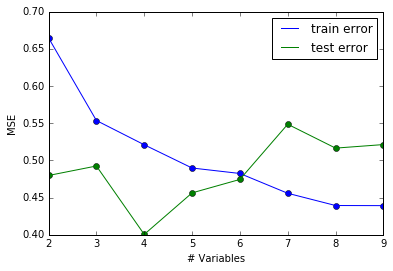

In [11]:
%matplotlib inline

plt.xlabel('# Variables')
plt.ylabel('MSE')
plt.plot(range(2,10),result_train,'bo')
train_line, = plt.plot(range(2,10),result_train,'b-')
plt.plot(range(2,10),result_test,'go')
test_line, = plt.plot(range(2,10),result_test,'g-')
plt.legend([train_line,test_line],['train error','test error'],loc=1)

plt.show()

Al mirar el gráfico se puede apreciar que al agregar las tres primeras variables el error en el conjunto de pruebas se minimiza. Posterior a ello se produce un sobre-ajuste a medida que el error de entrenamiento disminuye y el de pruebas aumenta.

## Backward Step-wise Selection (BSS)

**Backward Step-wise Selection (BSS)** es una técnica similar. En este caso se comienza con un modelo con todas las características. En cada iteración se prueba sacando una característica del modelo de acuerdo a un puntaje. Se escoje aquella que mejore el puntaje y se remueve del modelo. Este proceso continua hasta que el modelo empeore o se cumpla un criterio de parada.

De igual forma, se implementó BSS usando el valor absoluto de los pesos de cada predictor o característica al construirse el modelo. En cada iteración se ajustaba el modelo, se veía cual era la característica con el peso más bajo y se removía. En este caso no se incluyó un criterio de parada de forma de poder observar como va cambiando el error cuadrático medio conforme se retiran características.

In [16]:

import sklearn.linear_model as lm
import code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Definicion de bss
#x, y corresponden al conjunto y vector de entrenamiento respectivamente
#xt, yt corresponden al conjunto y vector de prueba respectivamente
#names_x los nombres de las características
#k el número máximo de características
def bss(x, y, xt, yt, names_x, k = 1):
	p = x.shape[1]-1
	k = min(p, k)
	names_x = np.array(names_x)
	remaining = range(0, p)
	selected = range(0,p+1)
	current_score = 0.0
	best_new_score = 0.0
	results_train = []
	results_test = []
	
	model = lm.LinearRegression(fit_intercept=False)
	model.fit(x,y)
	residuals_train = model.predict(x) - y
	results_train.append(np.mean(np.power(residuals_train, 2)))
	residuals_test = model.predict(xt) - yt
	results_test.append(np.mean(np.power(residuals_test, 2)))

	while len(remaining)>k and len(selected)>k:
		score_candidates = []
		for candidate in remaining:
			#ajustamos el modelo a lo actualmente seleccionado
			model = lm.LinearRegression(fit_intercept=False)
			x_train = x[:,selected]
			model.fit(x_train,y)
			wscore_candidate = abs(model.coef_[selected.index(candidate)])
			
			#removemos la variable y calculamos el training error por removerla
			indexes = selected[:]
			indexes.remove(candidate)
			x_train = x[:,indexes]
			model.fit(x_train, y)
			
			residuals_train = model.predict(x_train) - y
			mse_train_candidate = np.mean(np.power(residuals_train, 2))
			x_test = xt[:,indexes]
			residuals_test = model.predict(x_test) - yt
			mse_test_candidate = np.mean(np.power(residuals_test, 2))

			score_candidates.append((wscore_candidate, candidate, mse_train_candidate, mse_test_candidate))

		score_candidates.sort()
		score_candidates[:] = score_candidates[::-1]
		best_new_score, best_candidate, mse_train, mse_test = score_candidates.pop()
		remaining.remove(best_candidate)
		selected.remove(best_candidate)
		results_train.append(mse_train)
		results_test.append(mse_test)

		print "selected = %s ..."%names_x[best_candidate]
		print "totalvars=%d, abs_weight = %f"%(len(indexes),best_new_score)
		print "mse train=%f test=%f"%(mse_train,mse_test)

	return selected, results_train, results_test

                                          


In [17]:
names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45", "Intercept"]
selected, result_train, result_test = bss(Xm,ym,Xt,yt,names_regressors)

selected = Gleason ...
totalvars=8, abs_weight = 0.021195
mse train=0.439363 test=0.516513
selected = Age ...
totalvars=7, abs_weight = 0.144280
mse train=0.455818 test=0.548593
selected = Lbph ...
totalvars=6, abs_weight = 0.181826
mse train=0.480859 test=0.509882
selected = Pgg45 ...
totalvars=5, abs_weight = 0.226612
mse train=0.511548 test=0.437058
selected = Lcp ...
totalvars=4, abs_weight = 0.151438
mse train=0.521011 test=0.400531
selected = Svi ...
totalvars=3, abs_weight = 0.221538
mse train=0.553610 test=0.492482
selected = Lweight ...
totalvars=2, abs_weight = 0.314693
mse train=0.664606 test=0.479739


Se puede observar como BSS va quitando variable y va aumentando el error cuadrático medio del conjunto de entrenamiento, pero no así, el error cuadrático medio del conjunto de pruebas que va variando. Notar que la implementación no remueve la última variable. Notar que la tercera variable que saca no se corresponde con la antepenultima que ingreso FSS.

|            | lcavol | lweight | age    | lbph  | svi   | lcp    | gleason | pgg45 | intercept |
|------------|--------|---------|--------|-------|-------|--------|---------|-------|-----------|
|Coeficientes| **0.676**  | **0.262**   | -0.141 | **0.209** | **0.304** | -0.287 | -0.021  | **0.266** | **2.465**     |
|Z-score     | **5.366**  | **2.751**   | -1.396 | **2.056** | **2.469** | -1.867 | -0.147  | **1.738** | **27.598**|

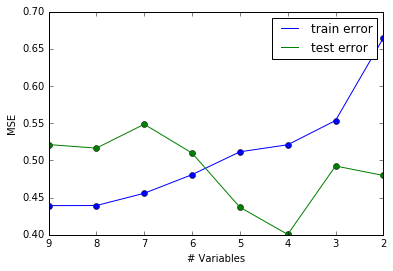

In [18]:
%matplotlib inline

ax = plt.gca()
ax.invert_xaxis()

plt.xlabel('# Variables')
plt.ylabel('MSE')
plt.plot(range(2,10)[::-1],result_train,'bo')
train_line, = plt.plot(range(2,10)[::-1],result_train,'b-')
plt.plot(range(2,10)[::-1],result_test,'go')
test_line, = plt.plot(range(2,10)[::-1],result_test,'g-')
plt.legend([train_line,test_line],['train error','test error'],loc=1)

plt.show()

Al mirar el gráfico se puede apreciar el cambio de BSS respecto de FSS en el cruce cuando remueve la tercera variable (cuando al modelo le quedan 6). El error de entrenamiento en este caso es mayor que al usar FSS en este punto. Sin embargo, al punto que al modelo quedaban 5 variables se puede ver que el comportamiento es igual y de hecho el mínimo del error de entrenamiento es el mismo.

## Conclusiones

Se implementó Forward Step-Wise Selection y Backward Step-Wise Selection. Se comprobó que ambos enfoques, aunque funcionan de manera inversa, pueden tener distintos resultados dependiendo del puntaje escogido. 

Al ver los errores de entrenamiento y de pruebas al incluir/remover variables del modelo se observó un cierto sobre-ajuste del modelo al incluir un gran número de variables. Por tanto, podría ser sensato considerar la eliminación de aquellas variables con baja influencia en el modelo y determinar un criterio de parada para evitar incluir estas variables al hacer uso de FSS (o de sacar en el caso de BSS).